The goal of this EDA is to explore the relationships between order cancellations and other variables in the data set and the relationships between variables.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
data = pd.read_csv('cancelations_data_clean.csv',parse_dates=['Order Date'])

In [3]:
data.head()

,Unnamed: 0,Order ID,Order Date,Fulfilment By,Sales Channel,Shipment Type,Style,SKU,Category,Size,...,Status Category,Price,Shipment State Matched,Free Financing,Free Shipping,Coupon,Other Promotions,No Promotions,Weekend,Stock
0,0,405-8078784-5731545,2022-04-30,Merchant,Amazon.in,Standard,SET389,SET389-KR-NP-S,Set,S,...,Cancelled,680.0,Maharashtra,False,False,False,False,True,True,32.0
1,1,171-9198151-1101146,2022-04-30,Merchant,Amazon.in,Standard,JNE3781,JNE3781-KR-XXXL,kurta,3XL,...,Shipped,406.0,Karnataka,True,False,False,False,False,True,96.0
2,2,404-0687676-7273146,2022-04-30,Amazon,Amazon.in,Expedited,JNE3371,JNE3371-KR-XL,kurta,XL,...,Shipped,329.0,Maharashtra,False,True,False,False,False,True,4.0
3,3,403-9615377-8133951,2022-04-30,Merchant,Amazon.in,Standard,J0341,J0341-DR-L,Western Dress,L,...,Cancelled,791.0,Puducherry,False,False,False,False,True,True,193.0
4,4,407-1069790-7240320,2022-04-30,Amazon,Amazon.in,Expedited,JNE3671,JNE3671-TU-XXXL,Top,3XL,...,Shipped,574.0,Tamil Nadu,False,False,False,False,True,True,6.0


In [4]:
data.drop(columns=['Unnamed: 0'],inplace=True)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120280 entries, 0 to 120279
Data columns (total 23 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   Order ID                120280 non-null  object        
 1   Order Date              120280 non-null  datetime64[ns]
 2   Fulfilment By           120280 non-null  object        
 3   Sales Channel           120280 non-null  object        
 4   Shipment Type           120280 non-null  object        
 5   Style                   120280 non-null  object        
 6   SKU                     120280 non-null  object        
 7   Category                120280 non-null  object        
 8   Size                    120280 non-null  object        
 9   Shipment City           120280 non-null  object        
 10  Shipment Postal Code    120280 non-null  int64         
 11  B2B                     120280 non-null  bool          
 12  Easy Ship               120280

In [6]:
# Checking how imbalanced my target feature is
data['Status Category'].value_counts(normalize=True)

Status Category
Shipped      0.856643
Cancelled    0.143357
Name: proportion, dtype: float64

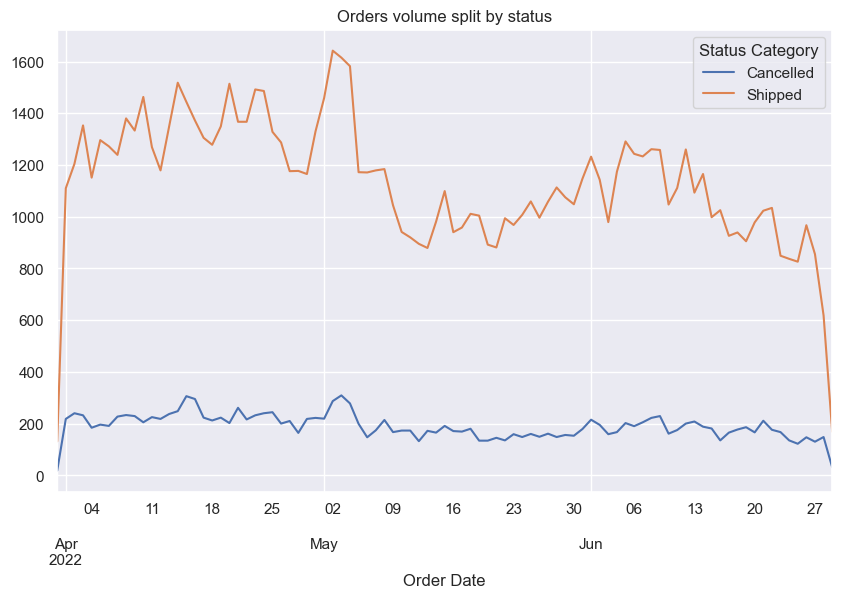

In [17]:
# Checking status trend over time
sns.set()
trend=data.groupby(['Order Date','Status Category']).size().unstack(fill_value=0)
trend.plot(kind='line',figsize=(10,6))
plt.title('Orders volume split by status')
plt.show()

There seem to be a drop in orders volume in May. I wonder if cancellation rate changed month on month.

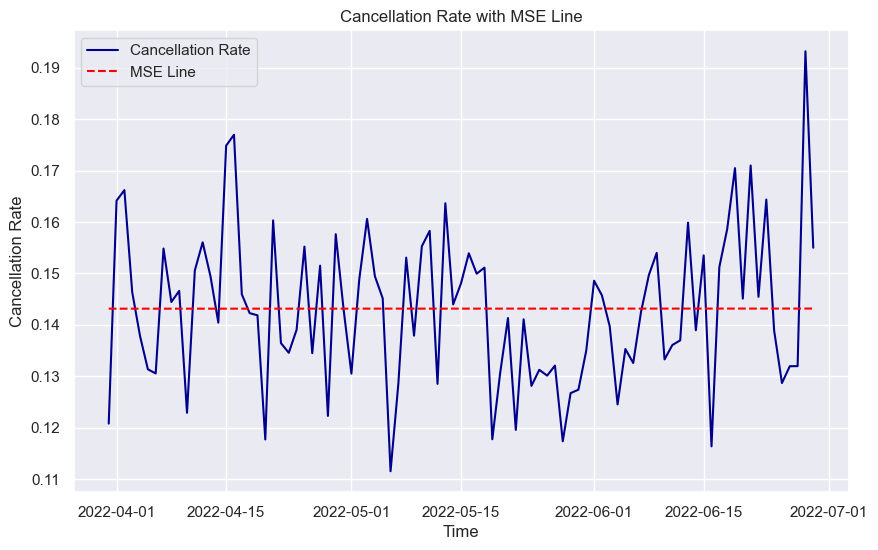

In [16]:
from sklearn.linear_model import LinearRegression

sns.set()

trend=data.groupby(['Order Date','Status Category']).size().unstack(fill_value=0)
trend['Cancellation Rate'] = trend['Cancelled'] / (trend['Cancelled'] + trend['Shipped'])

# Plot the Cancellation Rate
plt.figure(figsize=(10, 6))
plt.plot(trend.index, trend['Cancellation Rate'], label='Cancellation Rate', color='darkblue')

# Prepare data for linear regression
X = np.array(range(len(trend))).reshape(-1, 1)  # Reshape index to be a 2D array
y = trend['Cancellation Rate'].values

# Fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Get the predictions (MSE line)
y_pred = model.predict(X)

# Plot the MSE line
plt.plot(trend.index, y_pred, label='MSE Line', color='red', linestyle='--')

plt.title('Cancellation Rate with MSE Line')
plt.xlabel('Time')
plt.ylabel('Cancellation Rate')
plt.legend()
plt.show()

There are daily fluctuations in cancellation rate in the range between 11% and 19%, but there doesn't seem to be a change in cancellation rate trend.

In [8]:
# Writing a function to explore cancellation rate for different product features.
def explore_var(var, n, data=data):
    var_data = data.groupby([var, 'Status Category']).size().unstack(fill_value=0)
    var_data = var_data[['Shipped', 'Cancelled']].reset_index()
    var_data['Total'] = var_data['Cancelled'] + var_data['Shipped']
    var_data['Cancellation rate'] = var_data['Cancelled'] / var_data['Total']
    filtered_data = var_data[var_data['Total'] >= 100].sort_values(by='Cancellation rate', ascending=False)
    
    fig, ax1 = plt.subplots(figsize=(6, 4))
    
    # Bar plot for total orders
    sns.barplot(x=var, y='Total', data=filtered_data.head(n), ax=ax1, color='#B3CDE3')
    ax1.set_ylabel('Total Orders', color='#B3CDE3')
    ax1.tick_params(axis='y', labelcolor='#B3CDE3')
    ax1.set_ylim(0, ax1.get_ylim()[1])
    
    # Create a secondary y-axis
    ax2 = ax1.twinx()
    
    # Line plot for cancellation rate
    sns.lineplot(x=var, y='Cancellation rate', data=filtered_data.head(n), ax=ax2, color='red', marker='o')
    ax2.set_ylabel('Cancellation Rate', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim(0, 0.3)
    
    # Add a horizontal line for the mean cancellation rate
    mean_cancellation_rate = np.mean(var_data['Cancellation rate'])
    ax2.axhline(mean_cancellation_rate, color='black', linestyle='--', label='Mean Cancellation Rate')
    
    # Set the labels and title
    ax1.set_xlabel(var)
    ax1.set_xticklabels(ax1.get_xticklabels(), rotation=90)
    ax1.set_title(f'Volume & Cancellation Rate by {var} Relative to Mean')
    
    # Add legend
    ax2.legend(loc='upper right')
    
    plt.show()


/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


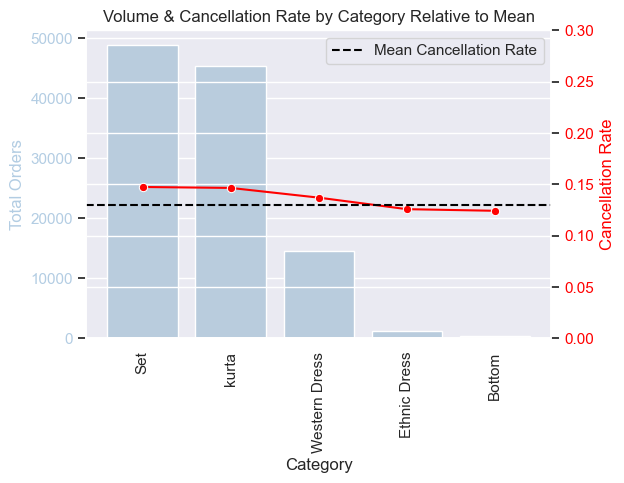

In [9]:
#Checking cancellation rate by product category
explore_var('Category',5)


Set & kurta have the highest cancellation rate and also the highest volume. I wonder if the differences in cancellation rate are significant.

In [10]:
#Writing a function for chi-squared test to check if difference between categories is significant.
def chi_squared(var):
    
    # Create a contingency table
    contingency_table = pd.crosstab(data[var], data['Status Category'])
    
    # Apply Chi-square test
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    expected_df = pd.DataFrame(expected, index=contingency_table.index, columns=contingency_table.columns)
    
    # Combine observed and expected frequencies
    combined_table = pd.concat([contingency_table, expected_df], axis=1, keys=['Observed', 'Expected'])
    
    # Print the results
    print(f"The null hypothesis is: cancellations do not depend on {var}.")
    print(f"\nChi-square Statistic: {chi2}")
    print(f"P-value: {p}")
    print(f"Degrees of Freedom: {dof}")
    
    # Interpretation
    alpha = 0.05
    if p < alpha:
        print("\nThe result is significant, we reject the null hypothesis.")
    else:
        print("\nThe result is not significant, we fail to reject the null hypothesis.")

    print("\nCombined Table (Observed and Expected Frequencies):")
    print(combined_table)

In [11]:
#Running chi-squared test to check if difference is significant.
chi_squared('Category')

The null hypothesis is: cancellations do not depend on Category.

Chi-square Statistic: 52.75960125285132
P-value: 4.135189959173193e-09
Degrees of Freedom: 7

The result is significant, we reject the null hypothesis.

Combined Table (Observed and Expected Frequencies):
                 Observed             Expected              
Status Category Cancelled Shipped    Cancelled       Shipped
Category                                                    
Blouse                102     728   118.986448    711.013552
Bottom                 50     353    57.772938    345.227062
Ethnic Dress          144    1002   164.287313    981.712687
Saree                  17     131    21.216861    126.783139
Set                  7204   41718  7013.319305  41908.680695
Top                  1101    7857  1284.193499   7673.806501
Western Dress        1982   12498  2075.811773  12404.188227
kurta                6643   38750  6507.411864  38885.588136


/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


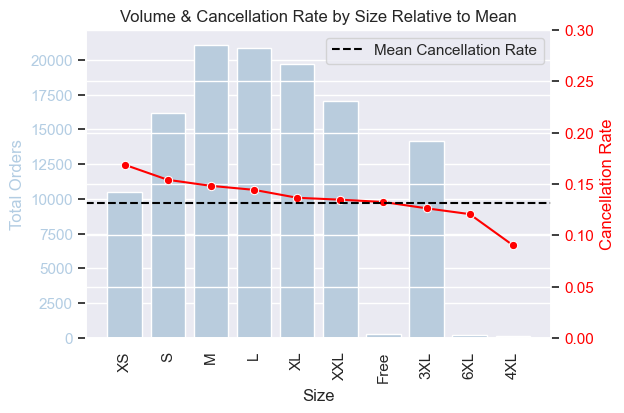

In [12]:
#Checking cancellation rate by product size.
explore_var('Size',10)

XS size has the highest cancellation rate.

In [13]:
#Running chi-squared test to check if difference is significant.

chi_squared('Size')

The null hypothesis is: cancellations do not depend on Size.

Chi-square Statistic: 134.22692378055262
P-value: 6.401575436920057e-24
Degrees of Freedom: 10

The result is significant, we reject the null hypothesis.

Combined Table (Observed and Expected Frequencies):
                 Observed             Expected              
Status Category Cancelled Shipped    Cancelled       Shipped
Size                                                        
3XL                  1787   12374  2030.080836  12130.919164
4XL                    13     131    20.643432    123.356568
5XL                    14     148    23.223861    138.776139
6XL                    27     197    32.112005    191.887995
Free                   36     236    38.993149    233.006851
L                    3004   17831  2986.846566  17848.153434
M                    3125   17979  3025.409644  18078.590356
S                    2493   13700  2321.382599  13871.617401
XL                   2688   17009  2823.706111  16873.293889

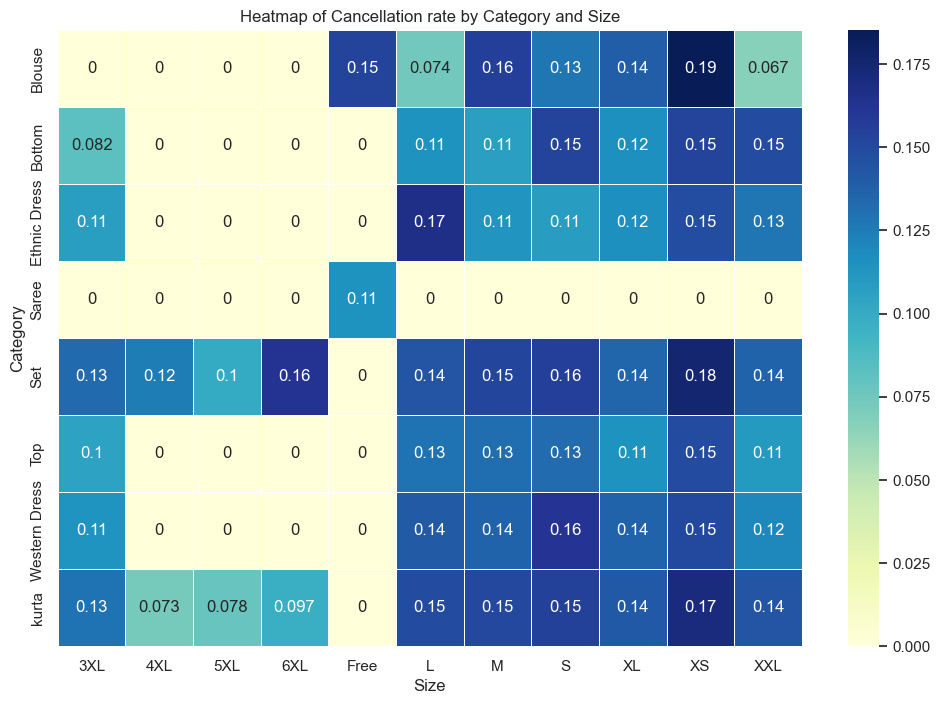

In [14]:
#Checking cancellation rate by category and size
category_data = data.groupby(['Category', 'Size', 'Status Category']).size().unstack(fill_value=0)
category_data = category_data[['Shipped', 'Cancelled']].reset_index()
category_data['Total'] = category_data['Cancelled'] + category_data['Shipped']
category_data['Cancellation rate'] = category_data['Cancelled'] / category_data['Total']

heatmap_data = category_data.pivot_table(index='Category', columns='Size', values='Cancellation rate', aggfunc='mean', fill_value=0)
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap='YlGnBu', annot=True, linewidths=.5)
plt.title('Heatmap of Cancellation rate by Category and Size')
plt.show()


Set, Blouse & kurta of XS size and Ethnic dress of L size have the highest cancellation rate. Perhaps there are so many returns because the size for these products is smaller or larger than what customers expect. I shall try to use Category and size in my model to predict cancelations.

Set


/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


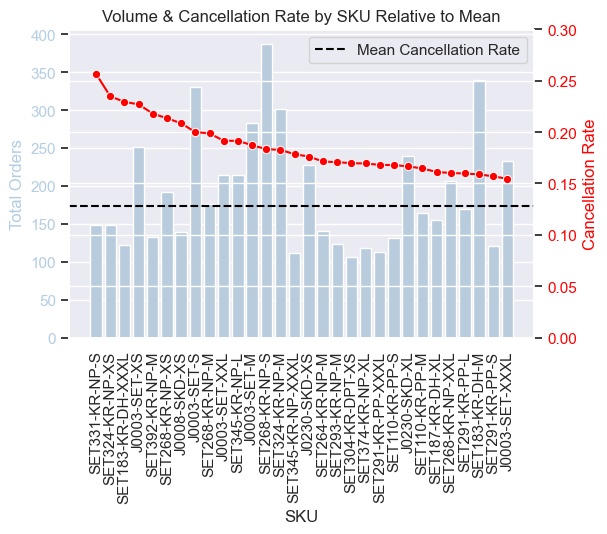

kurta


/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


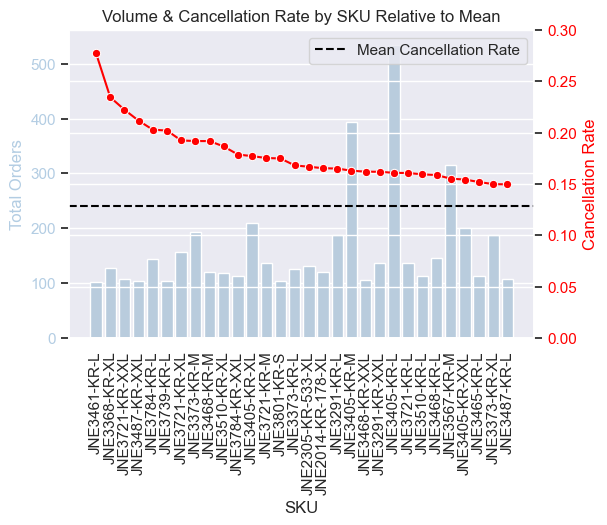

Western Dress


/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


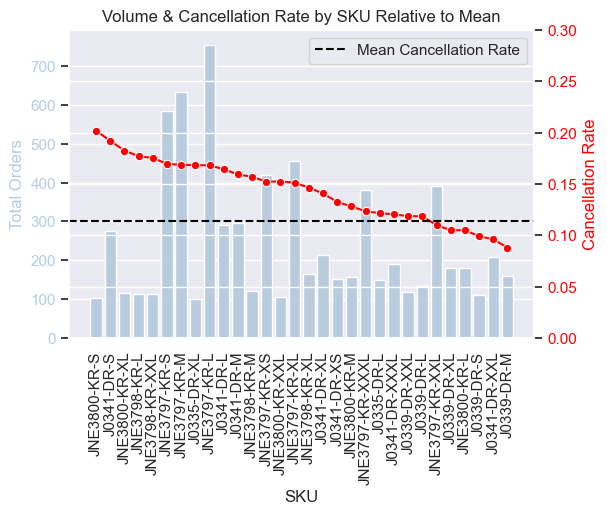

Top


/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


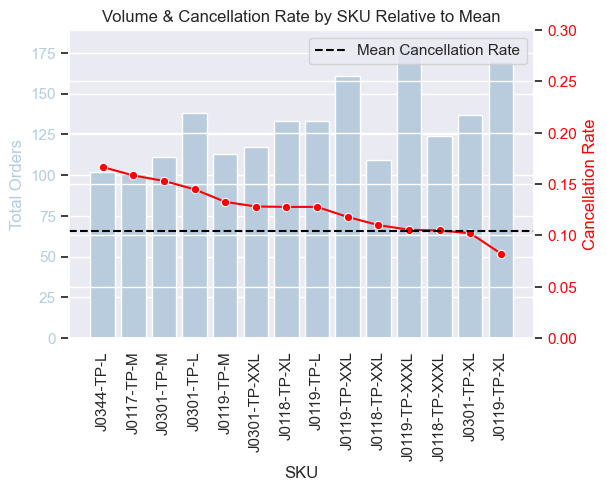

Ethnic Dress


ValueError: min() arg is an empty sequence

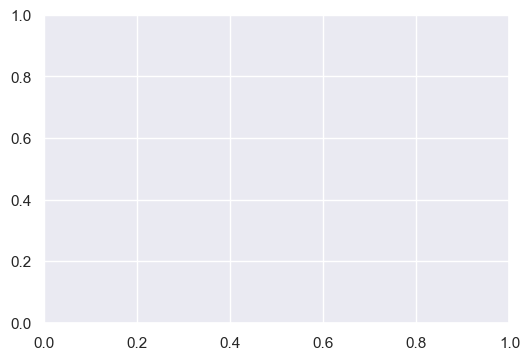

In [15]:
#Checking for which SKUs cancellation rate is the highest.
for i in data['Category'].unique():
    print(i)
    explore_var('SKU',30,data=data[data['Category']==i])


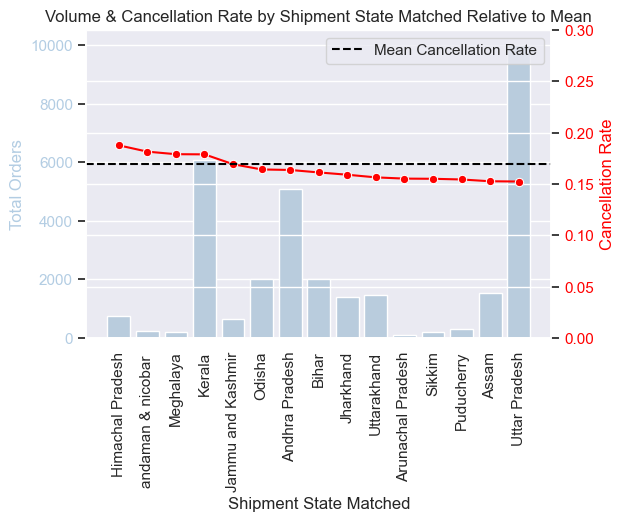

In [19]:
#Checking for which shipment states cancellation rates are the highest.
explore_var('Shipment State Matched', 15)

Kerala is a state with high volume of orders and high 

In [16]:
#Running chi-squared test to check if difference is significant. The null hypothesis is: cancellations do not depend on shipment state. 

chi_squared('Shipment State Matched')

The null hypothesis is: cancellations do not depend on Shipment State Matched.

Chi-square Statistic: 211.40799286763362
P-value: 1.0642853011326081e-26
Degrees of Freedom: 36

The result is significant, we reject the null hypothesis.

Combined Table (Observed and Expected Frequencies):
                                          Observed             Expected  \
Status Category                          Cancelled Shipped    Cancelled   
Shipment State Matched                                                    
Andaman and Nicobar Islands                     43     194    33.975648   
Andhra Pradesh                                 833    4259   729.974692   
Arunachal Pradesh                               18      98    16.629431   
Assam                                          233    1294   218.906393   
Bihar                                          324    1686   288.147905   
Chandigarh                                      36     274    44.440722   
Chhattisgarh                         

I shall try to use this column in my model.

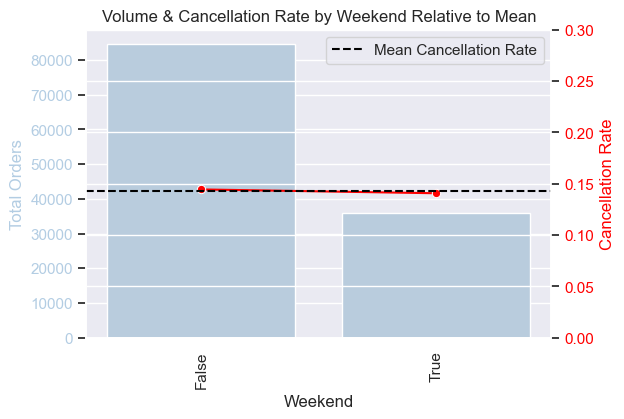

In [69]:
#Checking cancellation rates by weekend vs weekday.
explore_var("Weekend",2)

There doesn't seem to be big difference between the weekdays and weekend cancellation rate.

In [70]:
#Running chi-squared test. The null hypothesis is: cancellations do not depend on the day of the week. 

chi_squared('Weekend')

The null hypothesis is: cancellations do not depend on Weekend.

Chi-square Statistic: 2.807620268316557
P-value: 0.09381745150932594
Degrees of Freedom: 1

The result is not significant, we fail to reject the null hypothesis.

Combined Table (Observed and Expected Frequencies):
                 Observed              Expected              
Status Category Cancelled Shipped     Cancelled       Shipped
Weekend                                                      
False               12202   72261  12108.376363  72354.623637
True                 5041   30776   5134.623637  30682.376363


In [71]:
#Running chi-squared test. The null hypothesis is: cancellations do not depend on B2B. 

chi_squared('B2B')

The null hypothesis is: cancellations do not depend on B2B.

Chi-square Statistic: 21.242471931863435
P-value: 4.04696693020873e-06
Degrees of Freedom: 1

The result is significant, we reject the null hypothesis.

Combined Table (Observed and Expected Frequencies):
                 Observed              Expected               
Status Category Cancelled Shipped     Cancelled        Shipped
B2B                                                           
False               17174  102303  17127.884195  102349.115805
True                   69     734    115.115805     687.884195


Seems like with B2B orders we have less cancellations than expected. I will try using this column for my model.

In [72]:
#Running chi-squared test. The null hypothesis is: cancellations do not depend on Coupon. 

chi_squared('Coupon')


The null hypothesis is: cancellations do not depend on Coupon.

Chi-square Statistic: 157.58534670274767
P-value: 3.812811844961204e-36
Degrees of Freedom: 1

The result is significant, we reject the null hypothesis.

Combined Table (Observed and Expected Frequencies):
                 Observed              Expected               
Status Category Cancelled Shipped     Cancelled        Shipped
Coupon                                                        
False               17242  102083  17106.093906  102218.906094
True                    1     954    136.906094     818.093906


There's only one cancelled order for orders with coupon, when expected is 137.

In [74]:
chi_squared('No Promotions')

The null hypothesis is: cancellations do not depend on No Promotions.

Chi-square Statistic: 30586.11353547326
P-value: 0.0
Degrees of Freedom: 1

The result is significant, we reject the null hypothesis.

Combined Table (Observed and Expected Frequencies):
                 Observed              Expected              
Status Category Cancelled Shipped     Cancelled       Shipped
No Promotions                                                
False                 328   74004  10656.024909  63675.975091
True                16915   29033   6586.975091  39361.024909


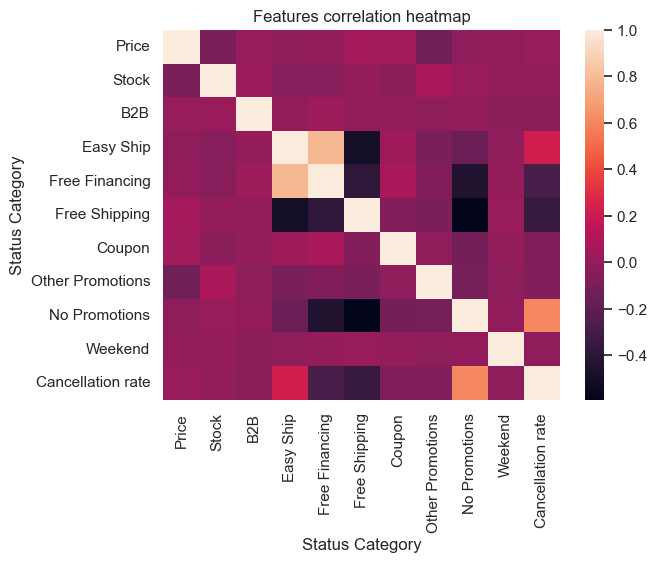

In [23]:
# Exploring Continuous and Boolean variables

cont_data = data.groupby(['Price','Stock','B2B', 'Easy Ship', 'Free Financing', 'Free Shipping', 'Coupon',
'Other Promotions', 'No Promotions', 'Weekend', 'Status Category']).size().unstack(fill_value=0)
cont_data = cont_data[['Shipped', 'Cancelled']].reset_index()
cont_data['Total'] = cont_data['Cancelled'] + cont_data['Shipped']
cont_data['Cancellation rate'] = cont_data['Cancelled'] / cont_data['Total']
cont_vars = cont_data[['Price','Stock','B2B', 'Easy Ship', 'Free Financing', 'Free Shipping', 'Coupon',
'Other Promotions', 'No Promotions', 'Weekend', 'Cancellation rate']]

sns.heatmap(cont_vars.corr())
plt.title('Features correlation heatmap')
plt.show()

Cancellation rate seem to be positively correlated with No promotions & Easy ship and negatively correlated with Free Shipping & Free Financing. The hypothesis here could be that with No promotions customers have higher expectation/less satisfaction with the product. I will try using this column for my model.

/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


Text(0.5, 1.0, 'Cancellation rate vs Price')

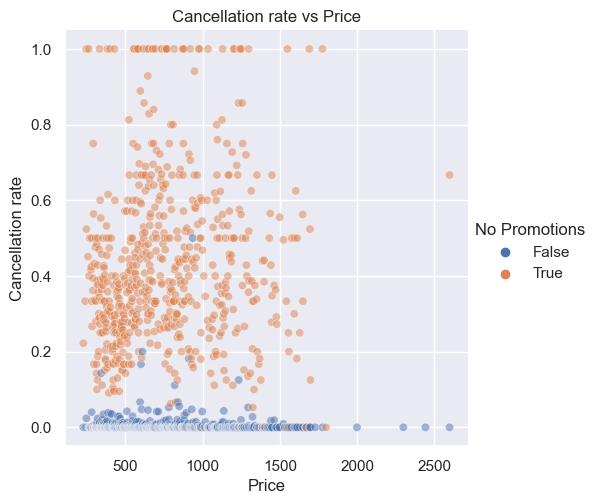

In [24]:
#Exploring relationship between price and cancellation rate.

price_data = data.groupby(['Price','No Promotions','Status Category']).size().unstack(fill_value=0)
price_data = price_data[['Shipped', 'Cancelled']].reset_index()
price_data['Total'] = price_data['Cancelled'] + price_data['Shipped']
price_data['Cancellation rate'] = price_data['Cancelled'] / price_data['Total']


sns.relplot(x='Price', y='Cancellation rate', data=price_data, kind='scatter',hue='No Promotions',alpha=0.5)
plt.title("Cancellation rate vs Price")

There does not appear to be any relationship between Price and Cancellation rate and a clear-cut relationship between Cancellation rate and No Promotions. 

/Users/nataliiashcheglova/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


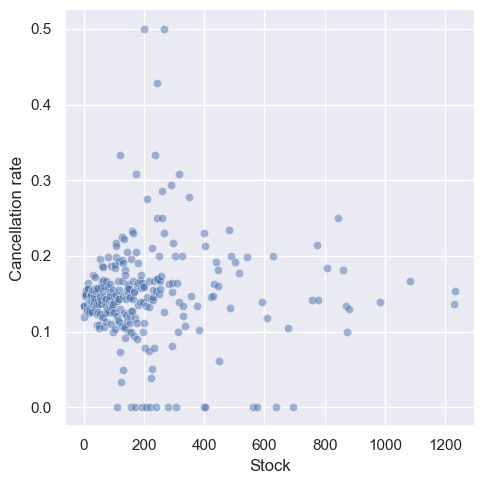

In [19]:
#Exploring relationship between stock and cancellation rate

price_data = data.groupby(['Stock','Status Category']).size().unstack(fill_value=0)
price_data = price_data[['Shipped', 'Cancelled']].reset_index()
price_data['Total'] = price_data['Cancelled'] + price_data['Shipped']
price_data['Cancellation rate'] = price_data['Cancelled'] / price_data['Total']


sns.relplot(x='Stock', y='Cancellation rate', data=price_data,kind='scatter',alpha=0.5)

There does not appear to be any relationship between Stock and Cancellation rate.

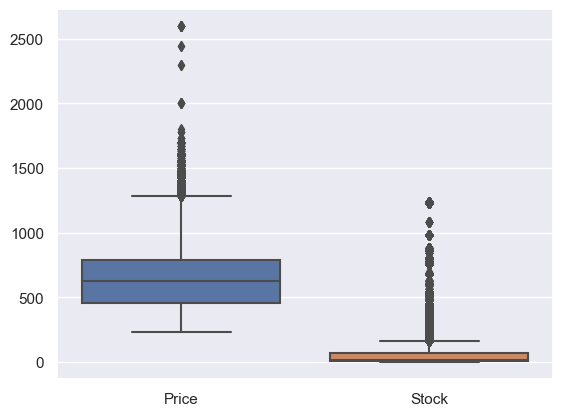

In [24]:
#Checking for outliers
sns.boxplot(data[['Price','Stock']])
plt.show()

There are outliers in both - Price and Stock values.